# ChEMBL structure pipeline

This notebook will cover basic operations with the [chembl_structure_pipeline](https://github.com/chembl/ChEMBL_Structure_Pipeline) package.

The [`chembl_structure_pipeline`](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00456-1) has three main components:

    1) Checker: checks if a give structure has any serious error and flags them. If an error is flagged, the molecule is scored according to the severity of the error. 

    2) Standardizer: normalize a structure according to a predefined set of rules (see below)

    3) GetParent: removes salts and solvents, and returns the parent molecule. 

## The standardization rules used by the Standardizer are:

- Standardize unknown stereochemistry (Handled by the RDKit Mol file parser)
- Fix wiggly bonds on sp3 carbons - sets atoms and bonds marked as unknown stereo to no stereo
- Fix wiggly bonds on double bonds – set double bond to crossed bond
- Clears S Group data from the mol file
- Kekulize the structure
- Remove H atoms (See the page on explicit Hs for more details)


### **Normalization**:
- Fix hypervalent nitro groups
- Fix KO to K+ O- and NaO to Na+ O- (Also add Li+ to this)
- Correct amides with N=COH
- Standardise sulphoxides to charge separated form
- Standardize diazonium N (atom :2 here: [*:1]-[N;X2:2]#[N;X1:3]>>[*:1]) to N+
- Ensure quaternary N is charged
- Ensure trivalent O ([*:1]=[O;X2;v3;+0:2]-[#6:3]) is charged
- Ensure trivalent S ([O:1]=[S;D2;+0:2]-[#6:3]) is charged
- Ensure halogen with no neighbors ([F,Cl,Br,I;X0;+0:1]) is charged
- The molecule is neutralized, if possible. See the page on neutralization rules for more details.
- Remove stereo from tartrate to simplify salt matching
- Normalise (straighten) triple bonds and allenes

In [1]:
#hide
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p numpy,pandas,rdkit -v

Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy : 1.20.1
pandas: 1.2.4
rdkit : 2021.03.5



In [2]:
import pandas as pd
import numpy as np
from rdkit.Chem import rdchem, SDMolSupplier, MolFromSmiles, MolToSmiles, MolFromMolBlock, MolToMolBlock, MolFromMol2Block, MolFromMolFile

from chembl_structure_pipeline import standardizer
from chembl_structure_pipeline import checker

from utils.Fingerprinter import Fingerprinter

In [3]:
data = pd.read_csv('../data/FXA_CHEMBL.csv',sep=',')
#data = data[~data['Standard Value'].isnull()]
#data[(data['Standard Relation']=="'='")].to_csv('../data/FXA_CHEMBL.csv',index=False)

In [4]:
data.head(2)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1144944,1,Scientific Literature,J. Med. Chem.,2003,None,NaN
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NC...,Ki,'=',...,Coagulation factor X,Homo sapiens,SINGLE PROTEIN,CHEMBL1133063,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,None,NaN


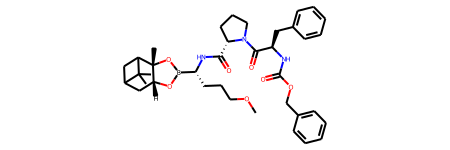

In [5]:
mol = MolFromSmiles(data.iloc[20]['Smiles'])
mol_block = MolToMolBlock(mol)
mol

In [6]:
from chembl_structure_pipeline import exclude_flag

# Checking molecules

In [7]:
checker_flags = checker.check_molblock(mol_block)
checker_flags

((2, 'molecule has a stereo bond in a ring'),)

In [8]:
error_score, error_flag = checker_flags[0]
error_score, error_flag

(2, 'molecule has a stereo bond in a ring')

The warnings 'InChI: Omitted undefined stereo','InChI: Charges were rearranged' are usually not very important and a large number of molecules may raise them. 

The standardizer does not catch molecules with at least one boron. Since I don't normally use molecules with B, we'll create a custom `exclude_flag` function to remove this kind of molecule before processing the data. 

In [9]:
# Zn not in the list as we have some Zn containing compounds in ChEMBL
# most of them are simple salts
METAL_LIST = [
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Ga", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Cd", "In", "Sn", "La", "Hf", "Ta",
    "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "Ac",
    "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm",
    "Yb", "Lu", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es",
    "Fm", "Md", "No", "Lr", "Ge", "Sb",
]


def exclude_flag(mol, includeRDKitSanitization=True):
    """
    Rules to exclude structures.
    - Metallic or non metallic with more than 7 boron atoms will be excluded
      due to problems when depicting borane compounds.
    """
    rdkit_fails = False
    exclude = False
    metallic = False
    boron_count = 0

    if type(mol) == str:
        mol = Chem.MolFromMolBlock(mol, sanitize=False)
        if includeRDKitSanitization:
            try:
                Chem.SanitizeMol(mol)
            except:
                rdkit_fails = True

    for atom in mol.GetAtoms():
        a_type = atom.GetSymbol()
        if a_type in METAL_LIST:
            metallic = True
        if a_type == "B":
            boron_count += 1

    if metallic or (not metallic and boron_count >= 1) or rdkit_fails:
        exclude = True
    return exclude

## Flagging molecules to exclude

In [10]:
data['mol'] = data['Smiles'].apply(lambda x : MolFromSmiles(x))
data['to_exclude'] = data['mol'].apply(exclude_flag)

In [11]:
data.groupby('to_exclude')['Molecule ChEMBL ID'].count().reset_index()

,to_exclude,Molecule ChEMBL ID
0,False,4045
1,True,43


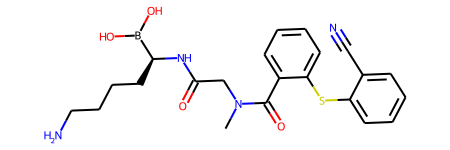

In [12]:
data[data['to_exclude']==True].mol.tolist()[-1]

In [13]:
data_trimmed = data[data['to_exclude']==False].reset_index(drop=True)
data_trimmed.shape

(4045, 47)

# Standardizing

In [14]:
std_molblock = standardizer.standardize_molblock(mol_block)

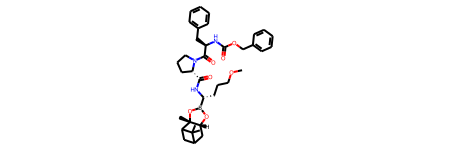

In [15]:
MolFromMolBlock(std_molblock)

# GetParent

In [16]:
parent_molblock, _ = standardizer.get_parent_molblock(mol_block)

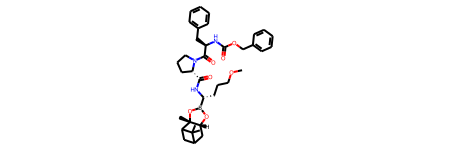

In [17]:
MolFromMolBlock(parent_molblock)

# Combining all operations

Let's create a function that let's us process a bunch of molecules at the same time. 

In [18]:
mol_list = data_trimmed.Smiles.tolist()
len(mol_list)

4045

In [19]:
def multi_molblock(mol_list):
    '''Converts a list of Mol objects into MolBlocks'''
    
    molblocks = []
    invalid_mols = []
    
    for struct in mol_list:
        if isinstance(struct, rdchem.Mol):
            try:
                molblocks.append(MolToMolBlock(struct))
            except:
                invalid_mols.append(struct)
                continue
        else:
            try:
                mol = MolFromSmiles(struct)
                molblocks.append(MolToMolBlock(mol))
                
            except:
                invalid_mols.append(struct)
                continue
    return tuple(zip(mol_list, molblocks)), invalid_mols

In [20]:
all_molblocks, invalid_mols = multi_molblock(mol_list)

In [21]:
len(all_molblocks)

4045

In [22]:
print(len(invalid_mols),len(all_molblocks))

0 4045


In [23]:
assert len(invalid_mols)+len(all_molblocks) == len(mol_list)

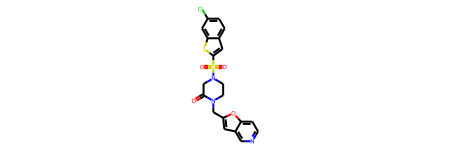

In [26]:
MolFromMolBlock(all_molblocks[0][1])

**GetParent**

In [27]:
def molblocktosmiles(molblock):
    return MolToSmiles(MolFromMolBlock(molblock))

In [28]:
def multi_getparent(mol_blocks):
    '''Generate the parent compound for each compound in the dataset'''
    parents = []
    for mol, molblock in mol_blocks:
        parent_molblock, _ = standardizer.get_parent_molblock(molblock)
        parents.append((mol, molblocktosmiles(parent_molblock)))
        
    return parents

In [29]:
parents = multi_getparent(all_molblocks)

RDKit INFO: [19:42:04] Initializing Normalizer
RDKit INFO: [19:42:07] Running Normalizer
RDKit INFO: [19:42:07] Running Uncharger
RDKit INFO: [19:42:07] Running Uncharger
RDKit INFO: [19:42:07] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INF

RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:42:28] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:42:29] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:42:30] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:42:31] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:42:32] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:42:33] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:34] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:42:35] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:42:36] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:42:37] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:38] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:42:39] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:42:40] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:42:41] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:42:42] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:42:43] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:42:44] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:42:45] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:42:46] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:42:47] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:42:48] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:42:49] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:

In [30]:
parents_df = pd.DataFrame(parents,columns=['Smiles','ParentSmiles'])

In [31]:
data_trimmed.shape, parents_df.shape

((4045, 47), (4045, 2))

In [32]:
for idx in range(len(data_trimmed)):
    assert data_trimmed.iloc[idx].Smiles == parents_df.iloc[idx].Smiles

In [33]:
cols_to_use = data_trimmed.columns.difference(parents_df.columns)
cols_to_use

Index(['#RO5 Violations', 'AlogP', 'Assay Cell Type', 'Assay ChEMBL ID',
       'Assay Description', 'Assay Organism', 'Assay Parameters',
       'Assay Subcellular Fraction', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Type', 'Assay Variant Accession',
       'Assay Variant Mutation', 'BAO Format ID', 'BAO Label',
       'Cell ChEMBL ID', 'Comment', 'Compound Key', 'Data Validity Comment',
       'Document ChEMBL ID', 'Document Journal', 'Document Year',
       'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Molecular Weight',
       'Molecule ChEMBL ID', 'Molecule Max Phase', 'Molecule Name',
       'Potential Duplicate', 'Properties', 'Source Description', 'Source ID',
       'Standard Relation', 'Standard Type', 'Standard Units',
       'Standard Value', 'Target ChEMBL ID', 'Target Name', 'Target Organism',
       'Target Type', 'Uo Units', 'mol', 'pChEMBL Value', 'to_exclude'],
      dtype='object')

In [34]:
kk = pd.concat([data_trimmed,parents_df['ParentSmiles']],join='outer',axis=1)

In [35]:
kk

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,mol,to_exclude,ParentSmiles
0,CHEMBL351435,NaN,0,461.95,0,3.73,16,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...,Ki,'=',...,CHEMBL1144944,1,Scientific Literature,J. Med. Chem.,2003,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa258414d00>,False,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...
1,CHEMBL295802,NaN,0,493.01,0,2.14,18,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NC...,Ki,'=',...,CHEMBL1133063,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa258414d60>,False,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NC...
2,CHEMBL62509,NaN,0,382.44,0,4.32,15m,C[C@H]1CC[C@@H](Oc2cccc(-c3nc4cc(C(=N)N)c(F)cc...,Ki,'=',...,CHEMBL1135195,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa258414dc0>,False,C[C@H]1CC[C@@H](Oc2cccc(-c3nc4cc(C(=N)N)c(F)cc...
3,CHEMBL416912,NaN,0,499.55,0,1.27,NC4,COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N...,Ki,'=',...,CHEMBL1136066,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa258414e20>,False,COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N...
4,CHEMBL140349,NaN,0,514.57,1,2.86,24b,Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)n(-c...,Ki,'=',...,CHEMBL1145122,1,Scientific Literature,J. Med. Chem.,2003,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa258414e80>,False,Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2)n(-c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040,CHEMBL3628957,NaN,0,530.46,2,6.42,74,Cc1ccc2c(c1)c(C)c1n2C[C@@](NC(=O)c2c(Cl)cc(-n3...,Ki,'=',...,CHEMBL3627625,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2015,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa25840cbe0>,False,Cc1ccc2c(c1)c(C)c1n2C[C@@](NC(=O)c2c(Cl)cc(-n3...
4041,CHEMBL4466116,NaN,0,1156.07,2,3.35,26,N=C(N)c1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN...,Ki,'=',...,CHEMBL4425109,1,Scientific Literature,J Med Chem,2016,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa25840cc40>,False,N=C(N)c1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN...
4042,CHEMBL4437656,NaN,0,1151.07,2,2.51,40,NCc1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN3CCN...,Ki,'=',...,CHEMBL4425109,1,Scientific Literature,J Med Chem,2016,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa25840cca0>,False,NCc1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN3CCN...
4043,CHEMBL298415,NaN,0,347.38,0,3.23,1,N=C(N)c1ccc(Oc2cccc(Oc3ccc(C(=N)N)cc3)n2)cc1,Ki,'=',...,CHEMBL3098065,1,Scientific Literature,ACS Med. Chem. Lett.,2013,None,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa25840cd00>,False,N=C(N)c1ccc(Oc2cccc(Oc3ccc(C(=N)N)cc3)n2)cc1


**Standardizing**

In [36]:
def multi_standardizing(mol_blocks):
    '''Generate the parent compound for each compound in the dataset'''
    standardized_mols = []
    for mol, molblock in mol_blocks:

        standardized_molblock = standardizer.standardize_molblock(molblock)
        standardized_mols.append((mol, molblocktosmiles(standardized_molblock)))
        
    return standardized_mols

In [37]:
std_mols = multi_standardizing(all_molblocks)

RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:42:50] Running Uncharger
RDKit INFO: [19:

RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKi

RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKi

RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKit INFO: [19:42:52] Running Uncharger
RDKit INFO: [19:42:52] Running Normalizer
RDKi

RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKi

RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKi

RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKit INFO: [19:42:53] Running Normalizer
RDKit INFO: [19:42:53] Running Uncharger
RDKi

RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKi

RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKi

RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKit INFO: [19:42:54] Running Uncharger
RDKit INFO: [19:42:54] Running Normalizer
RDKi

RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKi

RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKi

RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKit INFO: [19:42:55] Running Normalizer
RDKit INFO: [19:42:55] Running Uncharger
RDKi

RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKi

RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKi

RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKit INFO: [19:42:56] Running Uncharger
RDKit INFO: [19:42:56] Running Normalizer
RDKi

RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKi

RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKi

RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKit INFO: [19:42:57] Running Normalizer
RDKit INFO: [19:42:57] Running Uncharger
RDKi

RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKi

RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKi

RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKit INFO: [19:42:58] Running Uncharger
RDKit INFO: [19:42:58] Running Normalizer
RDKi

RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKi

RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKi

RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKit INFO: [19:42:59] Running Normalizer
RDKit INFO: [19:42:59] Running Uncharger
RDKi

RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKi

RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKi

RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKit INFO: [19:43:00] Running Normalizer
RDKit INFO: [19:43:00] Running Uncharger
RDKi

RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKit INFO: [19:43:01] Running Uncharger
RDKit INFO: [19:43:01] Running Normalizer
RDKi

In [38]:
std_molblock = standardizer.standardize_molblock(all_molblocks[0][1])

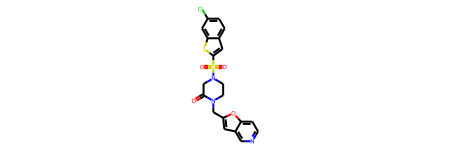

In [39]:
MolFromMolBlock(std_molblock)